[Back](https://keqideng.github.io/data_analysis_portfolio_project/)
# Chinese Eateries Analysis
Date: Sept 27, 2021

Prepared by ***Keqi Deng***

>This dataset is made available by [Yelp Fusion AIP](https://www.yelp.com/developers), the usage of the dataset is subject to the terms and conditions of Yelp.

In [56]:
import gc # garbage collector
import numpy as np # linear algebra
from collections import Counter # for counting commong words
import requests
# request data from yelp
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization
plt.style.use('fivethirtyeight') # use ggplot ploting style
import json
#load the census data
import seaborn as sns # visualization
from wordcloud import WordCloud, STOPWORDS # this module is for making wordcloud in python
import re # regular expression
import string # for finding punctuation in text
import nltk # preprocessing text
from textblob import TextBlob
# import ploty for visualization
import plotly
import plotly.offline as py # make offline
py.init_notebook_mode(connected=True)
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.graph_objs import *
import plotly.tools as tls
import plotly.figure_factory as fig_fact
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# this will allow ploting inside the notebook
%matplotlib inline

## Data Source
Firstly use Yelp Fusion API to pull data from Yelp for further analysis.

The selecting criteria is the Chinese restaurants in New York City.

In [57]:
def yelp_business_search(offset=0, location = 'NYC', lim = 50, term = 'restaurants,chinese', endpoint = 'https://api.yelp.com/v3/businesses/search'):
    #Business Search Yelp 'https://api.yelp.com/v3/businesses/search'
    client_id = 'By4LztDH6ULQMoOWW73Uag'
    #This is a private api key, please get your own api key by access yelp fusion api website.
    api_key = 'hC90EyLZwRlSqQGxIzbg_t8CAfz0aFyIovi270VIjCqEGHBx8xXyPGW4HUQoIh2ELaArE7Lw3zIM9aLkJQkuREJs5S4G1HtBx43eFCpvnP8IebL-uZk2CBKfFqxQYXYx'

    headers = {'Authorization': 'bearer %s'%api_key}

    #Define the parameters
    params = {'term': term,
              'limit':lim,
              'offset': offset,
              'location':location,
              'radius':40000}

    #Make a request to the yelp api
    response = requests.get(url=endpoint, params=params, headers=headers)

    #Convert json string to dictionary
    business_data = response.json()
    return pd.DataFrame(business_data['businesses'])

Here we select 250 top rating Chinese restaurants near New York City.

In [58]:
df = yelp_business_search(location='Manhattan')
for i in range(50,200,50):
    df = pd.concat([df,yelp_business_search(offset=i, location='Manhattan')])
for i in range(0,200,50):
    df = pd.concat([df,yelp_business_search(offset=i, location='Queens')])
for i in range(0,150,50):
    df = pd.concat([df,yelp_business_search(offset=i, location='Brooklyn')])
for i in range(0,200,50):
    df = pd.concat([df,yelp_business_search(offset=i, location='Bronx')])

## Dataset Modification
> Modify and prepare the datasets for further analysis and mapping.

In [59]:
#modify the coordinate data
coordinates = df.coordinates
lat = [i['latitude'] for i in coordinates]
lon = [i['longitude'] for i in coordinates]
df['latitude'] = lat
df['longitude'] = lon
df.drop('coordinates',axis=1,inplace=True)
df['city'] = [i['city'] for i in df.location]
df['state'] = [i['state'] for i in df.location]
df['postal'] = [i['zip_code'] for i in df.location]

In [60]:
# Dataset information
yelp_df = df.copy()
yelp_df[:1]

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,price,location,phone,display_phone,distance,latitude,longitude,city,state,postal
0,0CjK3esfpFcxIopebzjFxA,joes-shanghai-new-york-2,Joe's Shanghai,https://s3-media4.fl.yelpcdn.com/bphoto/KRvabB...,False,https://www.yelp.com/biz/joes-shanghai-new-yor...,6444,"[{'alias': 'shanghainese', 'title': 'Shanghain...",4.0,"[pickup, delivery]",$$,"{'address1': '46 Bowery St', 'address2': '', '...",+12122338888,(212) 233-8888,5351.172286,40.715661,-73.996701,New York,NY,10013


In [61]:
# Dataset length:
len(yelp_df)

750

In [62]:
#locate the middle of the map by calculate the mean of the latitude and longitude
lat_mean = yelp_df.latitude.mean()
lon_mean = yelp_df.longitude.mean()

# import plotly for plotting interactive map
hov_label = yelp_df['name']

# use mapbox token
#this is a private token key, please access mapbox for your own token
tkn = 'pk.eyJ1IjoicGF0cmlja2RkZCIsImEiOiJja3R5dGluOWEzNzE3MzFvMzR0MjRlZWVtIn0.ezHYtubmTTHs1z2n11c7yQ'

data = Data([Scattermapbox(lat=yelp_df.latitude.tolist(),
                           lon=yelp_df.longitude.tolist(),
                                       mode='markers',
                                       text=hov_label)])
layout = Layout(title='Chinese Restaurants on Yelp',
                autosize=True,
                hovermode='closest',
                mapbox=dict(accesstoken=tkn,
                            bearing=0,
                            center=dict(lat=lat_mean, lon=lon_mean),
                            style='light',
                            pitch=0,
                            zoom=9))

fig=dict(data=data, layout=layout)
plotly.offline.iplot(fig, filename='mapbox')

## Trend Identification
Identify the trend of the restaurants by comparing the population data from US census. Data organized by [Microsoft Azure](https://docs.microsoft.com/en-us/azure/open-datasets/dataset-us-population-zip?tabs=azureml-opendatasets)

About the Dataset:
>US population by gender and race for each US ZIP code sourced from 2000 and 2010 Decennial Census.
>
> This dataset is sourced from United States Census Bureau’s Decennial Census Dataset APIs. Review Terms of Service and Policies and Notices for the terms and conditions related to the use this dataset.

In [63]:
# This is a package in preview.
from azureml.opendatasets import UsPopulationZip

population = UsPopulationZip()
population_df = population.to_pandas_dataframe()

Upload failed. OSError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1108)>


[Info] read from /var/folders/df/l_7_3v3s13b0w6_jwtd7kkrh0000gn/T/tmpd293180t/https%3A/%2Fazureopendatastorage.azurefd.net/censusdatacontainer/release/us_population_zip/year=2010/part-00178-tid-5434563040420806442-84b5e4ab-8ab1-4e28-beb1-81caf32ca312-1919656.c000.snappy.parquet


In [64]:
population_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19077120 entries, 0 to 19077119
Data columns (total 7 columns):
 #   Column         Dtype  
---  ------         -----  
 0   decennialTime  object 
 1   zipCode        object 
 2   population     int32  
 3   race           object 
 4   sex            object 
 5   minAge         float64
 6   maxAge         float64
dtypes: float64(2), int32(1), object(4)
memory usage: 946.1+ MB


In [65]:
yelp_by_zip = pd.pivot_table(data=yelp_df, index='postal', values='name',
                             aggfunc=np.count_nonzero)

Here we only consider race as a factor, not gander.

In [66]:
pop_by_zip = pd.pivot_table(data=population_df, index='zipCode',
                            columns='race', values='population',
                            aggfunc=np.sum)
pop_by_zip['total']=pop_by_zip['AMERICAN INDIAN AND ALASKA NATIVE ALONE']+pop_by_zip['ASIAN ALONE']+pop_by_zip['BLACK OR AFRICAN AMERICAN ALONE']+pop_by_zip['NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE']+pop_by_zip['SOME OTHER RACE ALONE']+pop_by_zip['TWO OR MORE RACES']+pop_by_zip['WHITE ALONE']
pop_by_zip.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33120 entries, 00601 to 99929
Data columns (total 8 columns):
 #   Column                                            Non-Null Count  Dtype
---  ------                                            --------------  -----
 0   AMERICAN INDIAN AND ALASKA NATIVE ALONE           33120 non-null  int32
 1   ASIAN ALONE                                       33120 non-null  int32
 2   BLACK OR AFRICAN AMERICAN ALONE                   33120 non-null  int32
 3   NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE  33120 non-null  int32
 4   SOME OTHER RACE ALONE                             33120 non-null  int32
 5   TWO OR MORE RACES                                 33120 non-null  int32
 6   WHITE ALONE                                       33120 non-null  int32
 7   total                                             33120 non-null  int32
dtypes: int32(8)
memory usage: 1.3+ MB


In [67]:
#only consider asian population and its effect on Chinese restaurants:
pop_by_zip_asian = pop_by_zip[['ASIAN ALONE','total']]
pop_by_zip_asian['asian_rate']=pop_by_zip_asian['ASIAN ALONE']/pop_by_zip_asian.total

In [68]:
restaurant_count_by_zip_pop = pd.merge(yelp_by_zip,pop_by_zip_asian, how='left', left_index=True, right_index=True)
restaurant_count_by_zip_pop.info()
restaurant_count_by_zip_pop.columns = ['restaurant_count','asian_pop','total_pop','asian_pct']

<class 'pandas.core.frame.DataFrame'>
Index: 149 entries, 07010 to 11791
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         149 non-null    int64  
 1   ASIAN ALONE  148 non-null    float64
 2   total        148 non-null    float64
 3   asian_rate   148 non-null    float64
dtypes: float64(3), int64(1)
memory usage: 9.9+ KB


Restaurant Count by Asian Population

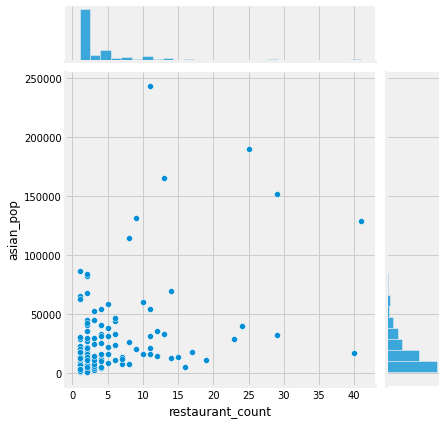

In [69]:
sns.jointplot(data=restaurant_count_by_zip_pop, x='restaurant_count', y='asian_pop')

Restaurant Count by Asian Population Rate

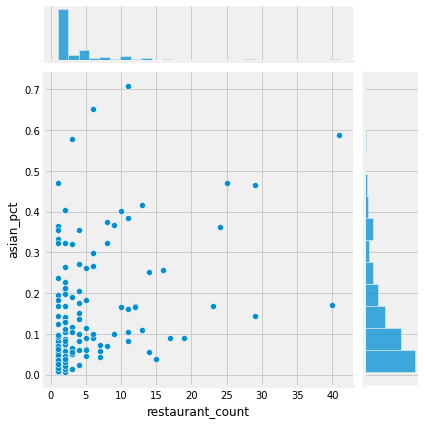

In [70]:
sns.jointplot(data=restaurant_count_by_zip_pop, x='restaurant_count', y='asian_pct')

In [71]:
yp_ithaca_df=yelp_business_search(location='14850', lim=50, term='chinese')

coordinates = yp_ithaca_df.coordinates
lat = [i['latitude'] for i in coordinates]
lon = [i['longitude'] for i in coordinates]
yp_ithaca_df['latitude'] = lat
yp_ithaca_df['longitude'] = lon
yp_ithaca_df.drop('coordinates',axis=1,inplace=True)
yp_ithaca_df['city'] = [i['city'] for i in yp_ithaca_df.location]
yp_ithaca_df['state'] = [i['state'] for i in yp_ithaca_df.location]
yp_ithaca_df['postal'] = [i['zip_code'] for i in yp_ithaca_df.location]

lat_mean = yp_ithaca_df.latitude.mean()
lon_mean = yp_ithaca_df.longitude.mean()

# import plotly for plotting interactive map
hov_label = yp_ithaca_df['name']

# use mapbox token
#this is a private token key, please access mapbox for your own token
tkn = 'pk.eyJ1IjoicGF0cmlja2RkZCIsImEiOiJja3R5dGluOWEzNzE3MzFvMzR0MjRlZWVtIn0.ezHYtubmTTHs1z2n11c7yQ'

data = Data([Scattermapbox(lat=yp_ithaca_df.latitude.tolist(),
                           lon=yp_ithaca_df.longitude.tolist(),
                           mode='markers',
                           text=hov_label)])
layout = Layout(title='Chinese Restaurants on Yelp',
                autosize=True,
                hovermode='closest',
                mapbox=dict(accesstoken=tkn,
                            bearing=0,
                            center=dict(lat=lat_mean, lon=lon_mean),
                            style='light',
                            pitch=0,
                            zoom=10))

fig=dict(data=data, layout=layout)
plotly.offline.iplot(fig, filename='mapbox')

In [72]:
yp_ithaca_df=yelp_business_search(location='14850', lim=50, term='mexican')

coordinates = yp_ithaca_df.coordinates
lat = [i['latitude'] for i in coordinates]
lon = [i['longitude'] for i in coordinates]
yp_ithaca_df['latitude'] = lat
yp_ithaca_df['longitude'] = lon
yp_ithaca_df.drop('coordinates',axis=1,inplace=True)
yp_ithaca_df['city'] = [i['city'] for i in yp_ithaca_df.location]
yp_ithaca_df['state'] = [i['state'] for i in yp_ithaca_df.location]
yp_ithaca_df['postal'] = [i['zip_code'] for i in yp_ithaca_df.location]

lat_mean = yp_ithaca_df.latitude.mean()
lon_mean = yp_ithaca_df.longitude.mean()

# import plotly for plotting interactive map
hov_label = yp_ithaca_df['name']

# use mapbox token
#this is a private token key, please access mapbox for your own token
tkn = 'pk.eyJ1IjoicGF0cmlja2RkZCIsImEiOiJja3R5dGluOWEzNzE3MzFvMzR0MjRlZWVtIn0.ezHYtubmTTHs1z2n11c7yQ'

data = Data([Scattermapbox(lat=yp_ithaca_df.latitude.tolist(),
                           lon=yp_ithaca_df.longitude.tolist(),
                           mode='markers',
                           text=hov_label)])
layout = Layout(title='Mexican Restaurants on Yelp',
                autosize=True,
                hovermode='closest',
                mapbox=dict(accesstoken=tkn,
                            bearing=0,
                            center=dict(lat=lat_mean, lon=lon_mean),
                            style='light',
                            pitch=0,
                            zoom=10))

fig=dict(data=data, layout=layout)
plotly.offline.iplot(fig, filename='mapbox')

In [73]:
yp_ithaca_df=yelp_business_search(location='14850', lim=50, term='italian')

coordinates = yp_ithaca_df.coordinates
lat = [i['latitude'] for i in coordinates]
lon = [i['longitude'] for i in coordinates]
yp_ithaca_df['latitude'] = lat
yp_ithaca_df['longitude'] = lon
yp_ithaca_df.drop('coordinates',axis=1,inplace=True)
yp_ithaca_df['city'] = [i['city'] for i in yp_ithaca_df.location]
yp_ithaca_df['state'] = [i['state'] for i in yp_ithaca_df.location]
yp_ithaca_df['postal'] = [i['zip_code'] for i in yp_ithaca_df.location]

lat_mean = yp_ithaca_df.latitude.mean()
lon_mean = yp_ithaca_df.longitude.mean()

# import plotly for plotting interactive map
hov_label = yp_ithaca_df['name']

# use mapbox token
#this is a private token key, please access mapbox for your own token
tkn = 'pk.eyJ1IjoicGF0cmlja2RkZCIsImEiOiJja3R5dGluOWEzNzE3MzFvMzR0MjRlZWVtIn0.ezHYtubmTTHs1z2n11c7yQ'

data = Data([Scattermapbox(lat=yp_ithaca_df.latitude.tolist(),
                           lon=yp_ithaca_df.longitude.tolist(),
                           mode='markers',
                           text=hov_label)])
layout = Layout(title='Italian Restaurants on Yelp',
                autosize=True,
                hovermode='closest',
                mapbox=dict(accesstoken=tkn,
                            bearing=0,
                            center=dict(lat=lat_mean, lon=lon_mean),
                            style='light',
                            pitch=0,
                            zoom=10))

fig=dict(data=data, layout=layout)
plotly.offline.iplot(fig, filename='mapbox')

In [74]:
yp_ithaca_df=yelp_business_search(location='14850', lim=50, term='american')

coordinates = yp_ithaca_df.coordinates
lat = [i['latitude'] for i in coordinates]
lon = [i['longitude'] for i in coordinates]
yp_ithaca_df['latitude'] = lat
yp_ithaca_df['longitude'] = lon
yp_ithaca_df.drop('coordinates',axis=1,inplace=True)
yp_ithaca_df['city'] = [i['city'] for i in yp_ithaca_df.location]
yp_ithaca_df['state'] = [i['state'] for i in yp_ithaca_df.location]
yp_ithaca_df['postal'] = [i['zip_code'] for i in yp_ithaca_df.location]

lat_mean = yp_ithaca_df.latitude.mean()
lon_mean = yp_ithaca_df.longitude.mean()

# import plotly for plotting interactive map
hov_label = yp_ithaca_df['name']

# use mapbox token
#this is a private token key, please access mapbox for your own token
tkn = 'pk.eyJ1IjoicGF0cmlja2RkZCIsImEiOiJja3R5dGluOWEzNzE3MzFvMzR0MjRlZWVtIn0.ezHYtubmTTHs1z2n11c7yQ'

data = Data([Scattermapbox(lat=yp_ithaca_df.latitude.tolist(),
                           lon=yp_ithaca_df.longitude.tolist(),
                           mode='markers',
                           text=hov_label)])
layout = Layout(title='American Restaurants on Yelp',
                autosize=True,
                hovermode='closest',
                mapbox=dict(accesstoken=tkn,
                            bearing=0,
                            center=dict(lat=lat_mean, lon=lon_mean),
                            style='light',
                            pitch=0,
                            zoom=10))

fig=dict(data=data, layout=layout)
plotly.offline.iplot(fig, filename='mapbox')